In [ ]:
!pip install praat-parselmouth

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 24.3 MB/s eta 0:00:00


In [ ]:
# 필요한 라이브러리 설치
!pip install pydub
!apt-get install ffmpeg  # Colab에서 FFmpeg 설치

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
from pydub import AudioSegment

# M4A 파일을 WAV로 변환
audio = AudioSegment.from_file("saturitest.m4a", format="m4a")
audio.export("saturitest.wav", format="wav")


<_io.BufferedRandom name='saturitest.wav'>

In [ ]:
!pip install noisereduce

  Using cached noisereduce-3.0.3-py3-none-any.whl.metadata (14 kB)


In [ ]:
import parselmouth
import noisereduce as nr
import numpy as np
import scipy.io.wavfile as wav

saturi_reduced.wav 파일이 생성되었습니다.
Pitch mean: 103.99 Hz, Pitch min: 78.86 Hz, Pitch max: 124.45 Hz


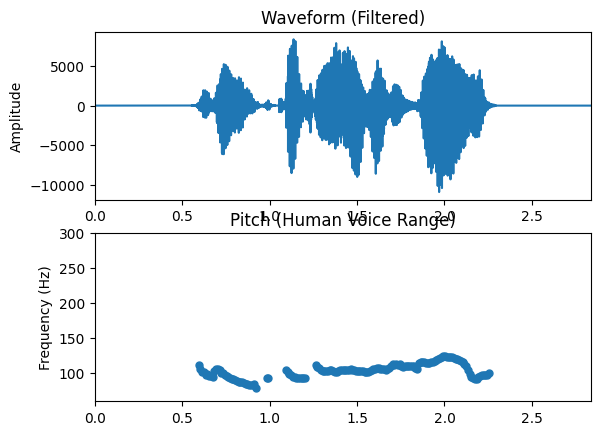

In [ ]:
import parselmouth
import noisereduce as nr
import scipy.io.wavfile as wav
import numpy as np
import matplotlib.pyplot as plt

# 1. WAV 파일 로드
file_path = "saturi.wav"

# scipy로 WAV 파일을 읽어서 샘플링 레이트와 데이터를 가져옴
sampling_rate, data = wav.read(file_path)

# 2. 노이즈 제거
# 노이즈만 있는 구간을 정의 (예: 처음 5000개의 샘플을 노이즈로 가정)
noise_clip = data[0:5000]

# 노이즈 제거 (노이즈 클립을 사용하여 노이즈 제거)
reduced_noise = nr.reduce_noise(y=data, sr=sampling_rate, y_noise=noise_clip, prop_decrease=0.9)

# 3. parselmouth로 음성 분석
snd = parselmouth.Sound(reduced_noise, sampling_rate)

# 4. 피치 분석
pitch = snd.to_pitch()

# 피치 값 가져오기 (인간 음역대 필터링)
pitch_values = pitch.selected_array['frequency']
human_voice_range = (30, 255)  # 사람 목소리 범위

# 5. 새로운 데이터 배열 생성
filtered_data = np.zeros_like(data)  # 원래 데이터와 같은 형태의 배열 생성

# 사람의 음역대에 해당하는 시간 인덱스를 찾아서 해당 부분만 저장
time_steps = pitch.xs()  # 피치 분석의 시간 단계

# 원본 데이터의 길이와 피치 분석의 시간 단계를 맞추기 위해, 각 시간 단계에 대해 필터링
for i, t in enumerate(time_steps):
    index = int(t * sampling_rate)  # 시간 단계를 샘플 인덱스로 변환
    if index < len(reduced_noise):  # 인덱스가 데이터 범위 내에 있는지 확인
        # 사람의 음역대에 해당하면 필터된 데이터에 복사
        if human_voice_range[0] <= pitch_values[i] <= human_voice_range[1]:
            # 인덱스의 주변 값을 포함하여 더 부드러운 전이 가능하도록
            start_index = max(0, index - int(sampling_rate / 25))  # 이전 구간의 일부를 포함 (25ms)
            end_index = min(len(filtered_data), index + int(sampling_rate / 25))  # 이후 구간의 일부를 포함 (25ms)
            filtered_data[start_index:end_index] = reduced_noise[start_index:end_index]

# 6. 노이즈 제거된 음성을 저장 (필터링된 데이터를 사용)
output_file = "saturi_reduced.wav"
wav.write(output_file, sampling_rate, filtered_data.astype(np.int16))

print(f"{output_file} 파일이 생성되었습니다.")

# 7. 피치 평균, 최소, 최대 계산
pitch_values_human = pitch_values[(pitch_values >= human_voice_range[0]) & (pitch_values <= human_voice_range[1])]

if pitch_values_human.size > 0:
    pitch_mean = np.mean(pitch_values_human)
    pitch_min = np.min(pitch_values_human)
    pitch_max = np.max(pitch_values_human)

    print(f"Pitch mean: {pitch_mean:.2f} Hz, Pitch min: {pitch_min:.2f} Hz, Pitch max: {pitch_max:.2f} Hz")
else:
    print("No pitch values found in the human voice range.")

# 8. 파형 및 피치 그래프 그리기
plt.figure()

# 파형 그리기
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(filtered_data)) / sampling_rate, filtered_data)
plt.xlim([0, len(filtered_data) / sampling_rate])
plt.ylabel("Amplitude")
plt.title("Waveform (Filtered)")

# 피치 그리기 (인간 음역대만 표시)
plt.subplot(2, 1, 2)
plt.plot(pitch.xs(), pitch.selected_array["frequency"], "o", markersize=5, label="Pitch")
plt.xlim([0, len(filtered_data) / sampling_rate])
plt.ylim(60, 300)  # 피치 범위 설정 (60 Hz에서 300 Hz)
plt.ylabel("Frequency (Hz)")
plt.title("Pitch (Human Voice Range)")
plt.show()
